#### Imports

In [145]:
import pandas as pd
from src.data_loader import load_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sketch
import plotly.express as px
from ydata_profiling import ProfileReport
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
import joblib, os

pd.set_option('display.max_columns', 50)
%matplotlib inline

In [119]:
# Use the project's data loader to load the CSV.
# Adjust the path as needed; insurance.csv is in the project root.
df = load_csv('../assets/numerical_dataset/insurance.csv')

# convert str columns to category dtype
df[['sex', 'smoker', 'region']] = df[['sex', 'smoker', 'region']].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


In [120]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [121]:
df.isnull().any().sum()

np.int64(0)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


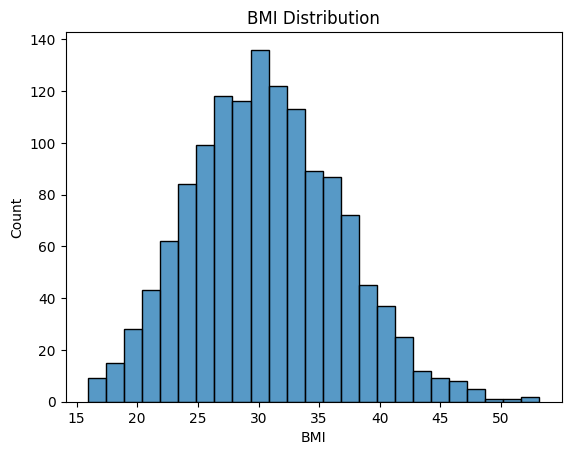

In [123]:
sns.histplot(data=df , x='bmi')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

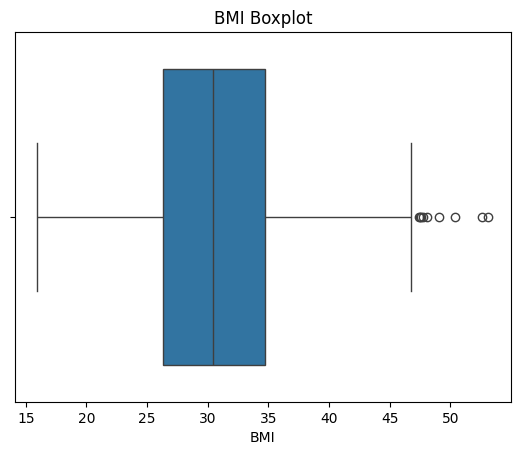

In [124]:
sns.boxplot(x='bmi', data=df)
plt.title('BMI Boxplot')
plt.xlabel('BMI')
plt.show()

#### Checking duplicates and removing them if there were any

In [125]:
# checking duplicate rows
df.duplicated().sum()

# show rows that are duplicates if there is any
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [126]:
# droping the duplicate rows if there any
df.drop_duplicates(keep='first', inplace=True)

#### Handling missing values

In [127]:
# checking if there is any missing values 
df.isnull().sum()


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### Checking for outliers

In [128]:
target_comlumn = 'bmi'
Q1 = df[target_comlumn].quantile(0.25)
Q3 = df[target_comlumn].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 2.5 * IQR
upper = Q3 + 2.5 * IQR

outlier_mask = (df[target_comlumn] < lower) | (df[target_comlumn] > upper)
outliers_bmi = df[outlier_mask]
outliers_bmi.head()

,age,sex,bmi,children,smoker,region,charges


#### Encode categorical data

In [137]:
categorical_cols = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_cols)
    ],
    remainder='passthrough',  # Keep non-categorical columns
    verbose_feature_names_out=False # Keeps column names clean
)

preprocessor.set_output(transform="pandas") 

df_encoded = preprocessor.fit_transform(df)
df_encoded.head(10)



,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children,charges
0,0.0,1.0,0.0,0.0,1.0,19,27.900,0,16884.92400
1,1.0,0.0,0.0,1.0,0.0,18,33.770,1,1725.55230
2,1.0,0.0,0.0,1.0,0.0,28,33.000,3,4449.46200
3,1.0,0.0,1.0,0.0,0.0,33,22.705,0,21984.47061
4,1.0,0.0,1.0,0.0,0.0,32,28.880,0,3866.85520
5,0.0,0.0,0.0,1.0,0.0,31,25.740,0,3756.62160
6,0.0,0.0,0.0,1.0,0.0,46,33.440,1,8240.58960
7,0.0,0.0,1.0,0.0,0.0,37,27.740,3,7281.50560
8,1.0,0.0,0.0,0.0,0.0,37,29.830,2,6406.41070
9,0.0,0.0,1.0,0.0,0.0,60,25.840,0,28923.13692


#### Spliting the data into training datset and testing dataset

In [140]:

# This splits the raw dataset into training and test sets 

TARGET = 'charges'  # adjust if you have a different target column
# Features (all columns except target) and label
X = df_encoded.drop(columns=[TARGET])
y = df_encoded[TARGET]


# split (80% train / 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# peek at the training features and labels
display(X_train.head())
display(y_train.head())

# Variables now available for modeling: X_train, X_test, y_train, y_test

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children
1114,1.0,0.0,0.0,0.0,0.0,23,24.510,0
968,1.0,0.0,0.0,0.0,0.0,21,25.745,2
599,0.0,0.0,1.0,0.0,0.0,52,37.525,2
170,1.0,0.0,0.0,1.0,0.0,63,41.470,0
275,0.0,0.0,0.0,0.0,0.0,47,26.600,2


1114     2396.09590
968      3279.86855
599     33471.97189
170     13405.39030
275      9715.84100
Name: charges, dtype: float64

#### Training of the liner regression model

In [ ]:
# fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

# evaluate
y_pred = lr.predict(X_test)
# Use sklearn.metrics functions for RMSE/MAE/R2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE : {mae:.2f}')
print(f'Test R^2 : {r2:.4f}')

# Cross-validated RMSE (5-fold) on the full dataset as a robust baseline
try:
    scores = cross_val_score(lr, X, y, cv=5, scoring='neg_root_mean_squared_error')
    print('5-fold CV RMSEs:', -scores)
    print('CV RMSE mean:', -scores.mean())
except Exception as e:
    print('Could not run cross_val_score:', e)

# # persist model
# os.makedirs('artifacts', exist_ok=True)
# joblib.dump(lr, 'artifacts/linear_regression_baseline.joblib')
# print('Saved baseline model to artifacts/linear_regression_baseline.joblib')

# # show coefficients if feature names available
# try:
#     coefs = pd.Series(lr.coef_, index=X_train.columns).sort_values(key=lambda s: s.abs(), ascending=False)
#     display(coefs.head(20))
# except Exception as e:
#     print('Could not display coefficients:', e)

Test RMSE: 5956.34
Test R^2 : 0.8069
5-fold CV RMSEs: [6088.06041918 6174.07708129 5717.03368594 6299.30585893 6092.97881455]
CV RMSE mean: 6074.291171978072


In [148]:
# Additional evaluation metrics and tolerance-based accuracy estimates
# Requires y_test and y_pred to be available (from the training cell).
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure predictions exist
if 'y_pred' not in globals():
    try:
        y_pred = lr.predict(X_test)
    except Exception as e:
        raise RuntimeError('y_pred not found and could not compute predictions. Run the training cell first.') from e
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')
print(f'MAE : {mae:.2f}')
print(f'R^2 : {r2:.4f}')

# Percent within relative tolerance (e.g., within 10% of true value)
tol = 0.10  # 10%
# Avoid division by zero when y_test is zero: use absolute check when y_test==0
rel_mask = np.abs(y_test - y_pred) <= tol * np.where(np.abs(y_test) > 0, np.abs(y_test), 1.0)
within_pct = rel_mask.mean() * 100
print(f'Percent within {int(tol*100)}% of true value: {within_pct:.2f}%')

# Percent within absolute thresholds (useful for business context)
for threshold in (500, 1000, 2000):
    within_abs = (np.abs(y_test - y_pred) <= threshold).mean() * 100
    print(f'Percent within ${threshold:,}: {within_abs:.2f}%')

# Optional: show residual diagnostics summary
residuals = y_test - y_pred
print('Residuals summary:')
print(residuals.describe())

# If you want a visual check, uncomment the plots below
# import matplotlib.pyplot as plt
# plt.figure(figsize=(6,4))
# plt.scatter(y_test, y_pred, alpha=0.6)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.xlabel('True charges')
# plt.ylabel('Predicted charges')
# plt.title('Predicted vs True')
# plt.show()

RMSE: 5956.34
MAE : 4177.05
R^2 : 0.8069
Percent within 10% of true value: 15.67%
Percent within $500: 11.57%
Percent within $1,000: 20.52%
Percent within $2,000: 40.67%
Residuals summary:
count      268.000000
mean       425.256995
std       5952.258087
min     -10314.509078
25%      -2732.812019
50%       -906.863946
75%       1805.380287
max      24111.221121
Name: charges, dtype: float64
